In [17]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [18]:
url = "https://raw.githubusercontent.com/jorgelizarazo94/Fundamentos_2/2b68b4cbdd3a0ff30c1442d9226ec50ec2d4970e/Parcial_1_timeseries/Examen.csv"
data = pd.read_csv(url)


In [19]:
data

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098
...,...,...,...
122,123,3664.610771,3429.293034
123,124,3650.881839,3437.099467
124,125,3651.788470,3453.155282
125,126,3637.047639,3472.528345


In [20]:
''''
Renombrar columna Unnamed: 0
'''
data.rename(columns={"Unnamed: 0": "ID"}, inplace=True)
data['Fecha'] = pd.date_range(start="2008-01-01", periods=len(data), freq='MS')
data.set_index('Fecha', inplace=True)


In [21]:
df =data
df

,ID,producto1,producto2
Fecha,,,
2008-01-01,1,4000.000000,3000.000000
2008-02-01,2,3997.400893,3010.686220
2008-03-01,3,3978.605317,3022.018584
2008-04-01,4,3986.454125,3033.920990
2008-05-01,5,3979.695678,3038.402098
...,...,...,...
2018-03-01,123,3664.610771,3429.293034
2018-04-01,124,3650.881839,3437.099467
2018-05-01,125,3651.788470,3453.155282


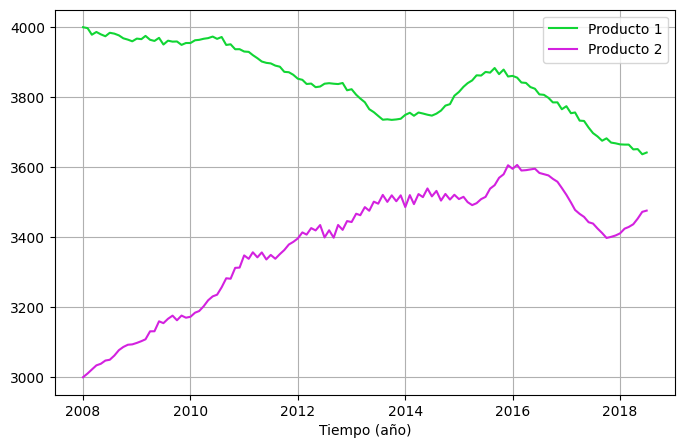

In [22]:
fig = plt.figure(figsize=(8, 5))
plt.title("")
plt.xlabel("Tiempo (año)")
plt.ylabel("")
plt.plot(df[["producto1"]], color='#11D534', label="Producto 1")
plt.plot(df[["producto2"]], color='#D321DF', label="Producto 2")
plt.legend()
plt.grid()

plt.show()


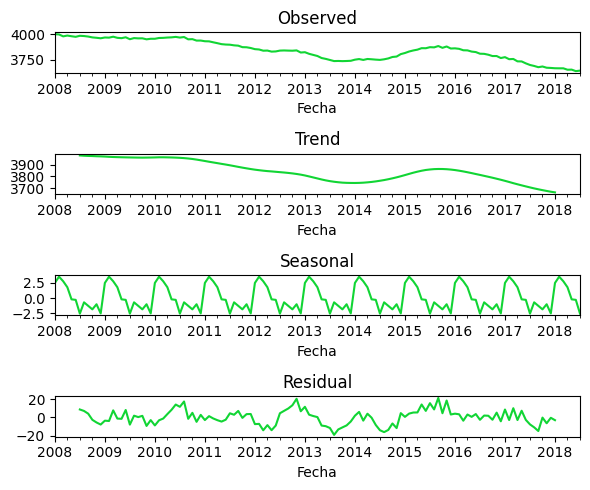

In [23]:
# Realizar la descomposición estacional
td_componentes = seasonal_decompose(df[["producto1"]], model="additive")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(6,5))

td_componentes.observed.plot(ax=ax1, color='#11D534')
td_componentes.trend.plot(ax=ax2, color='#11D534')
td_componentes.seasonal.plot(ax=ax3, color='#11D534')
td_componentes.resid.plot(ax=ax4, color='#11D534')
ax1.set_title("Observed")
ax2.set_title("Trend")
ax3.set_title("Seasonal")
ax4.set_title("Residual")

fig.tight_layout()
plt.show()

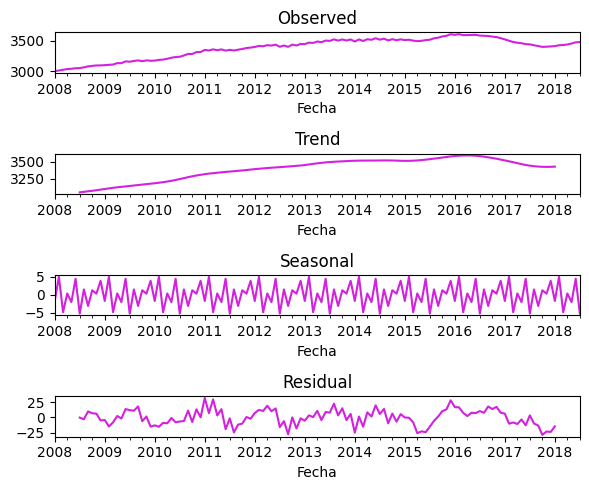

In [24]:
# Realizar la descomposición estacional
td_componentes2 = seasonal_decompose(df[["producto2"]], model="additive")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(6,5))

td_componentes2.observed.plot(ax=ax1, color='#D321DF')
td_componentes2.trend.plot(ax=ax2,color='#D321DF')
td_componentes2.seasonal.plot(ax=ax3, color='#D321DF')
td_componentes2.resid.plot(ax=ax4, color='#D321DF')
ax1.set_title("Observed")
ax2.set_title("Trend")
ax3.set_title("Seasonal")
ax4.set_title("Residual")

fig.tight_layout()
plt.show()

Definir si se trata de un Ruido Blanco

In [25]:
from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.api as sm


signo1 = td_componentes.resid>0
signo2 = td_componentes2.resid>0

runstest_1samp(signo1, correction=False)


(-4.133602185232747, 3.571214056964891e-05)

In [26]:
runstest_1samp(signo2, correction=False)


(-4.8900466019460005, 1.00812107909443e-06)

In [27]:

# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(signo1, lags=[1],
                        return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,16.729473,0.000043,16.340415,0.000053


In [28]:

                        # prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(signo2, lags=[1],
                        return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,23.475965,0.000001,22.930012,0.000002


**Los residuos no pertenecen a un ruido blanco, es decir hay autocorrelación**

In [29]:

Resul_lb_bp_P1 = sm.stats.acorr_ljungbox(signo1, lags=range(1,21),
                                      return_df=True,boxpierce=True )
Resul_lb_bp_P1["lb_ho"] = np.where(Resul_lb_bp_P1['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr',
                                'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp_P1["bp_ho"] = np.where(Resul_lb_bp_P1['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr',
                                'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp_P1.head(20)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,16.729473,4.310612e-05,16.340415,5.292314e-05,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,39.361637,2.836149e-09,38.270807,4.893277e-09,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,42.538151,3.084316e-09,41.324200,5.581595e-09,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,45.472935,3.170252e-09,44.122482,6.050724e-09,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,45.789932,1.002184e-08,44.422278,1.901216e-08,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,45.864517,3.150225e-08,44.492238,5.903467e-08,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,45.900071,9.142226e-08,44.525312,1.690622e-07,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,46.114403,2.260873e-07,44.723029,4.152579e-07,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,46.255560,5.398688e-07,44.852149,9.826126e-07,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,46.261416,1.285992e-06,44.857461,2.307339e-06,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


In [30]:

Resul_lb_bp_P2 = sm.stats.acorr_ljungbox(signo2, lags=range(1,21),
                                      return_df=True,boxpierce=True )
Resul_lb_bp_P2["lb_ho"] = np.where(Resul_lb_bp_P2['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr',
                                'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp_P2["bp_ho"] = np.where(Resul_lb_bp_P2['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr',
                                'no_rechazo_ho/no_hay_autocorr')


Resul_lb_bp_P2.head(20)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,23.475965,1.264841e-06,22.930012,1.680081e-06,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,49.919873,1.445564e-11,48.553954,2.861824e-11,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,54.666551,8.088114e-12,53.116652,1.731322e-11,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,57.692325,8.854405e-12,56.001692,2.003538e-11,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,58.012235,3.127236e-11,56.304243,7.034730e-11,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,58.075164,1.106418e-10,56.363270,2.457935e-10,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,61.355856,8.088725e-11,59.415076,1.975097e-10,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,61.986077,1.897611e-10,59.996443,4.668528e-10,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,64.082289,2.175437e-10,61.913908,5.725531e-10,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,64.099789,6.023581e-10,61.929780,1.560461e-09,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En la serie residual del modelo 4 si es muy contundente la decisión en los primeros 20 rezagos, es decir, los residuos del modelo con mejor MSE no parece comportarse como un ruido blanco, **Si presenta autocorrelación**

**Podemos proceder con algun tipo de split dado que en ninguno de los dos productos estaremos posiblemente frente a un ruido blanco**

## Producto 1

In [31]:
prediction_length = 6

# Almacenamos todas las predicciones de cada modelo
all_predictions = {
    "SES": [],
    "Holt": [],
    "HW Additive": [],
    "HW Multiplicative": []
}


for end in range(24, len(df) - prediction_length, prediction_length):
    train = df['producto1'][:end]
    test = df['producto1'][end:end + prediction_length]

    # Modelos
    ses_model = ExponentialSmoothing(train, trend=None, seasonal=None).fit()
    holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
    hw_add_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=6).fit()
    hw_mul_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=6).fit()

    # Predicciones
    ses_forecast = ses_model.forecast(prediction_length)
    holt_forecast = holt_model.forecast(prediction_length)
    hw_add_forecast = hw_add_model.forecast(prediction_length)
    hw_mul_forecast = hw_mul_model.forecast(prediction_length)

    # Acumulamos las predicciones
    all_predictions["SES"].extend(ses_forecast)
    all_predictions["Holt"].extend(holt_forecast)
    all_predictions["HW Additive"].extend(hw_add_forecast)
    all_predictions["HW Multiplicative"].extend(hw_mul_forecast)

# Una vez terminado el bucle, calculamos el RMSE global para cada modelo
true_values = df['producto1'][24:len(all_predictions["SES"]) + 24].values
'''
all_predictions["SES"] es simplemente una convención basada en
la suposición de que todas las listas de predicciones dentro de all_predictions
("SES", "Holt", "HW Additive" y "HW Multiplicative")
tendrán la misma longitud al final del bucle.
'''
global_rmse = {
    "SES": mean_squared_error(true_values, all_predictions["SES"], squared=False),
    "Holt": mean_squared_error(true_values, all_predictions["Holt"], squared=False),
    "HW Additive": mean_squared_error(true_values, all_predictions["HW Additive"], squared=False),
    "HW Multiplicative": mean_squared_error(true_values, all_predictions["HW Multiplicative"], squared=False)
}

# Mostrar resultados
for model, rmse in global_rmse.items():
    print(f"Modelo: {model} - RMSE global: {rmse:.2f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Modelo: SES - RMSE global: 26.09
Modelo: Holt - RMSE global: 22.02
Modelo: HW Additive - RMSE global: 20.82
Modelo: HW Multiplicative - RMSE global: 20.83



1.   Modelo: SES - RMSE global: 26.09
2.   Modelo: Holt - RMSE global: 22.02
3.   Modelo: HW Additive - RMSE global: 20.82
4.   Modelo: HW Multiplicative - RMSE global: 20.83

## Producto 2

In [32]:
prediction_length = 6

# Almacenamos todas las predicciones de cada modelo
all_predictions = {
    "SES": [],
    "Holt": [],
    "HW Additive": [],
    "HW Multiplicative": []
}


for end in range(24, len(df) - prediction_length, prediction_length):
    train2 = df['producto2'][:end]
    test2 = df['producto2'][end:end + prediction_length]

    # Modelos
    ses_model = ExponentialSmoothing(train2, trend=None, seasonal=None).fit()
    holt_model = ExponentialSmoothing(train2, trend='add', seasonal=None).fit()
    hw_add_model = ExponentialSmoothing(train2, trend='add', seasonal='add', seasonal_periods=6).fit()
    hw_mul_model = ExponentialSmoothing(train2, trend='add', seasonal='mul', seasonal_periods=6).fit()

    # Predicciones
    ses_forecast = ses_model.forecast(prediction_length)
    holt_forecast = holt_model.forecast(prediction_length)
    hw_add_forecast = hw_add_model.forecast(prediction_length)
    hw_mul_forecast = hw_mul_model.forecast(prediction_length)

    # Acumulamos las predicciones
    all_predictions["SES"].extend(ses_forecast)
    all_predictions["Holt"].extend(holt_forecast)
    all_predictions["HW Additive"].extend(hw_add_forecast)
    all_predictions["HW Multiplicative"].extend(hw_mul_forecast)

# Una vez terminado el bucle, calculamos el RMSE global para cada modelo
true_values = df['producto2'][24:len(all_predictions["SES"]) + 24].values
global_rmse = {
    "SES": mean_squared_error(true_values, all_predictions["SES"], squared=False),
    "Holt": mean_squared_error(true_values, all_predictions["Holt"], squared=False),
    "HW Additive": mean_squared_error(true_values, all_predictions["HW Additive"], squared=False),
    "HW Multiplicative": mean_squared_error(true_values, all_predictions["HW Multiplicative"], squared=False)
}

# Mostrar resultados
for model, rmse in global_rmse.items():
    print(f"Modelo: {model} - RMSE global: {rmse:.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Modelo: SES - RMSE global: 36.88
Modelo: Holt - RMSE global: 39.22
Modelo: HW Additive - RMSE global: 32.35
Modelo: HW Multiplicative - RMSE global: 32.22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)




1.   Modelo: SES - RMSE global: 36.88
2.   Modelo: Holt - RMSE global: 39.22
3.   Modelo: HW Additive - RMSE global: 32.35
4.   Modelo: HW Multiplicative - RMSE global: 32.22





# Modelos lineales y polinomicos

## Producto 1

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


# Inicializa lista para almacenar predicciones y errores
all_predictions = []
all_true_values = []

# Tamaño de la ventana (esto depende de ti, pero como ejemplo uso 24)
window_size = 24
prediction_length = 6

for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto1"][start:end]
    x_train = np.linspace(1, window_size, window_size)
    X_train = sm.add_constant(x_train)

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    X_pred = sm.add_constant(x_pred)
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto1"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de los errores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)



RMSE utilizando validación cruzada de ventana móvil: 50.20776356095574


In [ ]:
# Suponiendo que df es tu DataFrame y "producto 1" es tu columna objetivo

# Inicializa lista para almacenar predicciones y errores
all_predictions = []
all_true_values = []


for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto1"][start:end].reset_index(drop=True)
    x_train = np.linspace(1, window_size, window_size)
    x2_train = x_train**2
    X_train = sm.add_constant(pd.DataFrame({"x": x_train, "x2": x2_train}))

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    x2_pred = x_pred**2
    X_pred = sm.add_constant(pd.DataFrame({"x": x_pred, "x2": x2_pred}))
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto1"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)


RMSE utilizando validación cruzada de ventana móvil: 41.901468210145126


In [ ]:

# Inicializa lista para almacenar predicciones y errores
all_predictions = []
all_true_values = []



for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto1"][start:end].reset_index(drop=True)
    x_train = np.linspace(1, window_size, window_size)
    x2_train = x_train**2
    x3_train = x_train**3
    X_train = sm.add_constant(pd.DataFrame({"x": x_train, "x2": x2_train, "x3": x3_train}))

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    x2_pred = x_pred**2
    x3_pred = x_pred**3
    X_pred = sm.add_constant(pd.DataFrame({"x": x_pred, "x2": x2_pred, "x3": x3_pred}))
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto1"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)


RMSE utilizando validación cruzada de ventana móvil: 54.854999470479825


In [ ]:

# Inicializa lista para almacenar predicciones y errores
all_predictions = []
all_true_values = []


# Creación de dummies para todo el conjunto de datos
all_month_dummies = pd.get_dummies(df.index.month, drop_first=True).set_index(df.index)

for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto1"][start:end].reset_index(drop=True)
    x_train = np.linspace(1, window_size, window_size)
    x2_train = x_train**2
    month_dummies_train = all_month_dummies[start:end]
    X_train = pd.concat([pd.DataFrame({"x": x_train, "x2": x2_train}).reset_index(drop=True), month_dummies_train.reset_index(drop=True)], axis=1)
    X_train = sm.add_constant(X_train)

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    x2_pred = x_pred**2
    month_dummies_pred = all_month_dummies[end:end+prediction_length]
    X_pred = pd.concat([pd.DataFrame({"x": x_pred, "x2": x2_pred}).reset_index(drop=True), month_dummies_pred.reset_index(drop=True)], axis=1)
    X_pred = sm.add_constant(X_pred)
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto1"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)

RMSE utilizando validación cruzada de ventana móvil: 49.892981144730996


## Producto 2

In [ ]:

all_predictions = []
all_true_values = []


for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto2"][start:end]
    x_train = np.linspace(1, window_size, window_size)
    X_train = sm.add_constant(x_train)

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    X_pred = sm.add_constant(x_pred)
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto2"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de los errores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)


RMSE utilizando validación cruzada de ventana móvil: 53.1605016007388


In [ ]:

all_predictions = []
all_true_values = []


window_size = 24
prediction_length = 6

for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto2"][start:end].reset_index(drop=True)
    x_train = np.linspace(1, window_size, window_size)
    x2_train = x_train**2
    X_train = sm.add_constant(pd.DataFrame({"x": x_train, "x2": x2_train}))

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    x2_pred = x_pred**2
    X_pred = sm.add_constant(pd.DataFrame({"x": x_pred, "x2": x2_pred}))
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto2"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)


RMSE utilizando validación cruzada de ventana móvil: 59.7799555575646


In [ ]:

all_predictions = []
all_true_values = []


for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto2"][start:end].reset_index(drop=True)
    x_train = np.linspace(1, window_size, window_size)
    x2_train = x_train**2
    x3_train = x_train**3
    X_train = sm.add_constant(pd.DataFrame({"x": x_train, "x2": x2_train, "x3": x3_train}))

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    x2_pred = x_pred**2
    x3_pred = x_pred**3
    X_pred = sm.add_constant(pd.DataFrame({"x": x_pred, "x2": x2_pred, "x3": x3_pred}))
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto2"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)

RMSE utilizando validación cruzada de ventana móvil: 77.55882658554816


In [ ]:

all_predictions = []
all_true_values = []




all_month_dummies = pd.get_dummies(df.index.month, drop_first=True).set_index(df.index)

for start in range(0, len(df) - window_size - prediction_length + 1):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto2"][start:end].reset_index(drop=True)
    x_train = np.linspace(1, window_size, window_size)
    x2_train = x_train**2
    month_dummies_train = all_month_dummies[start:end]
    X_train = pd.concat([pd.DataFrame({"x": x_train, "x2": x2_train}).reset_index(drop=True), month_dummies_train.reset_index(drop=True)], axis=1)
    X_train = sm.add_constant(X_train)

    # Ajusta el modelo
    model = sm.OLS(y_train, X_train).fit()

    # Predice los siguientes 6 puntos
    x_pred = np.linspace(window_size + 1, window_size + prediction_length, prediction_length)
    x2_pred = x_pred**2
    month_dummies_pred = all_month_dummies[end:end+prediction_length]
    X_pred = pd.concat([pd.DataFrame({"x": x_pred, "x2": x2_pred}).reset_index(drop=True), month_dummies_pred.reset_index(drop=True)], axis=1)
    X_pred = sm.add_constant(X_pred)
    y_pred = model.predict(X_pred)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto2"][end:end+prediction_length].values
    all_true_values.extend(y_true)

# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil:", rmse)

RMSE utilizando validación cruzada de ventana móvil: 71.21959664318555


# ARIMA

## Producto 2

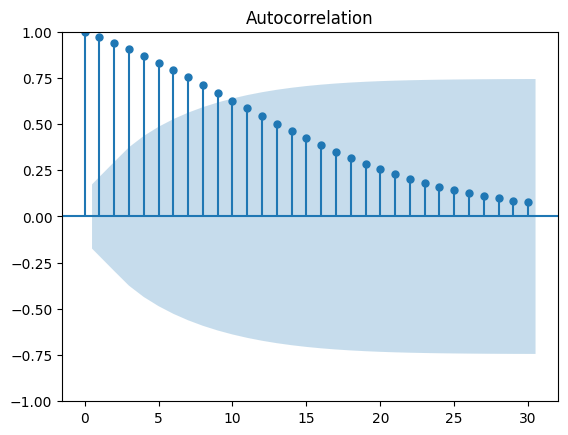

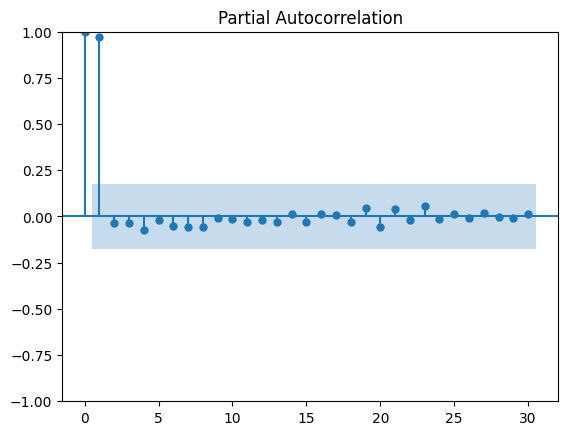

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(df['producto1'],lags=30);
plot_pacf(df['producto1'],lags=30);

Apparently AR

In [ ]:
#pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

model = auto_arima(df["producto1"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -428.175
Date:                Tue, 29 Aug 2023   AIC                            868.350
Time:                        15:58:57   BIC                            885.368
Sample:                    01-01-2008   HQIC                           875.264
                         - 07-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.9214      0.633     -1.455      0.146      -2.163       0.320
ar.L1          0.2768      0.131      2.121      0.034       0.021       0.533
ar.L2          0.4287      0.140      3.055      0.002       0.154       0.704
ma.L1         -0.4537      0.132     -3.450      0.001      -0.712      -0.196
ma.L2          0.3040      0.129      2.361      0.018       0.052       0.556
sigma2        51.8560      7.446      6.965      0.000      37.263      66.449
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.99   Prob(JB):                         0.58
Heteroskedasticity (H):               0.79   Skew:                            -0.13
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

apparently it could be ARIMA(2,1,2)

In [ ]:

all_predictions = []

# Tamaño de la ventana y longitud de la predicción
window_size = 24
prediction_length = 6

for start in range(0, len(df) - window_size - prediction_length + 1, prediction_length):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto1"][start:end]

    # Ajusta el modelo auto_arima
    model = auto_arima(y_train, max_p=10, max_q=10, information_criterion='aic', trace=False, seasonal=False) # He desactivado el 'trace' para no obtener demasiada salida

    # Predice los siguientes 6 puntos
    y_pred = model.predict(n_periods=prediction_length)
    all_predictions.extend(y_pred)

# Verdaderos valores siguientes
all_true_values = df["producto1"][window_size:window_size+len(all_predictions)].values

# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil con auto_arima:", rmse)

RMSE utilizando validación cruzada de ventana móvil con auto_arima: 23.995685480363008


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from pmdarima import auto_arima


all_predictions = []
all_true_values = []
models = []  # Almacena todos los modelos
errors = []  # Almacena RMSE de cada modelo

# Tamaño de la ventana y longitud de la predicción
window_size = 24
prediction_length = 6

for start in range(0, len(df) - window_size - prediction_length + 1, prediction_length):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto1"][start:end]

    # Ajusta el modelo auto ARIMA
    model = auto_arima(y_train, max_p=10, max_q=10, information_criterion='aic', trace=False, seasonal=False)

    # Predice los siguientes puntos
    y_pred = model.predict(n_periods=prediction_length)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto1"][end:end+prediction_length].values
    all_true_values.extend(y_true)

    # Almacena el modelo y su error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    models.append(model)
    errors.append(rmse)

# Encuentra el modelo con el menor error
min_index = np.argmin(errors)
best_model = models[min_index]

print("El mejor modelo ARIMA es:")
print(best_model.summary())
# Calcula el RMSE a partir de las predicciones y los verdaderos valores
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil con auto_arima:", rmse)

El mejor modelo ARIMA es:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 2, 0)   Log Likelihood                 -71.980
Date:                Tue, 29 Aug 2023   AIC                            147.959
Time:                        16:30:16   BIC                            150.141
Sample:                    07-01-2009   HQIC                           148.473
                         - 06-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8387      0.146     -5.733      0.000      -1.126      -0.552
sigma2        38.3297     11.335      3.381      0.001      16.113      60.547
Ljung-Box (L1) (Q):       

## Producto 2

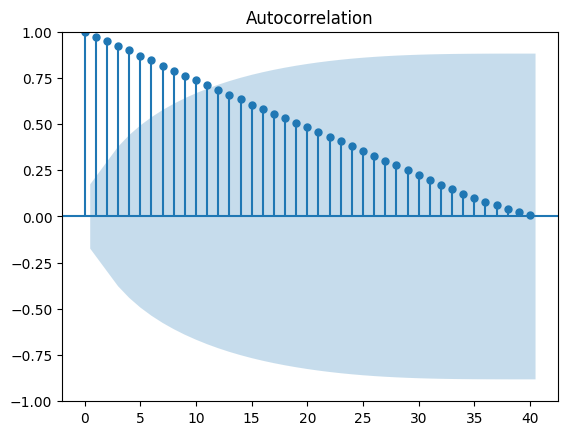

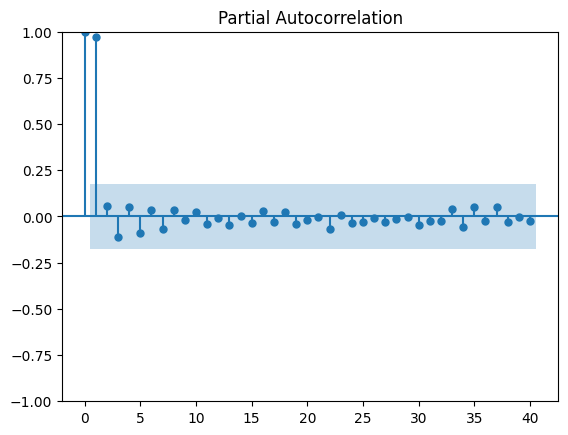

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(df['producto2'],lags=40);
plot_pacf(df['producto2'],lags=40);

In [ ]:
from pmdarima.arima import auto_arima

model = auto_arima(df["producto2"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -462.974
Date:                Tue, 29 Aug 2023   AIC                            933.949
Time:                        16:32:13   BIC                            945.262
Sample:                    01-01-2008   HQIC                           938.545
                         - 07-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0761      0.076     -1.004      0.316      -0.225       0.072
ar.L2          0.7510      0.081      9.315      0.000       0.593       0.909
ma.L1         -0.9841      0.039    -25.526      0.000      -1.060      -0.909
sigma2        94.1563     12.099      7.782      0.000      70.443     117.869
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.95   Prob(JB):                         0.73
Heteroskedasticity (H):               1.11   Skew:                            -0.17
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

apatentmente es un ARIMA(2,2,1)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from pmdarima import auto_arima

# Inicializa lista para almacenar predicciones y errores
all_predictions = []
all_true_values = []
models = []  # Almacena todos los modelos
errors = []  # Almacena RMSE de cada modelo

# Tamaño de la ventana y longitud de la predicción
window_size = 24
prediction_length = 6

for start in range(0, len(df) - window_size - prediction_length + 1, prediction_length):
    end = start + window_size

    # Datos de entrenamiento
    y_train = df["producto2"][start:end]

    # Ajusta el modelo auto ARIMA
    model = auto_arima(y_train, max_p=10, max_q=10, information_criterion='aic', trace=False, seasonal=False)

    # Predice los siguientes puntos
    y_pred = model.predict(n_periods=prediction_length)
    all_predictions.extend(y_pred)

    # Verdaderos valores siguientes
    y_true = df["producto2"][end:end+prediction_length].values
    all_true_values.extend(y_true)

    # Almacena el modelo y su error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    models.append(model)
    errors.append(rmse)

# Encuentra el modelo con el menor error
min_index = np.argmin(errors)
best_model = models[min_index]

print("El mejor modelo ARIMA es:")
print(best_model.summary())

rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
print("RMSE utilizando validación cruzada de ventana móvil con auto_arima:", rmse)

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,0,0)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "/usr/local/lib/python3.

El mejor modelo ARIMA es:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -80.088
Date:                Tue, 29 Aug 2023   AIC                            166.176
Time:                        16:35:47   BIC                            169.582
Sample:                    01-01-2008   HQIC                           167.032
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.0641      2.984      3.707      0.000       5.215      16.913
ar.L1         -0.4674      0.367     -1.275      0.202      -1.186       0.251
sigma2        61.2616     